In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

In [ ]:
import os

os.environ["BLACKMARBLE_TOKEN"]

'=== REDACTED $BLACKMARBLE_TOKEN ==='

In [ ]:
import os
from datetime import date, timedelta

import colorcet as cc
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
from matplotlib.colors import LogNorm
from pqdm.threads import pqdm
from rasterio.io import MemoryFile

from lib.admin_areas import get_region_avail_dates, get_region_gdf, get_region_meta
from lib.geotiff import merge_geotiffs
from lib.lj import lj_download_metadata, lj_download_tile
from lib.types import VNP46A1_Variable, VNP46A2_Variable

ADMIN_ID = "ESP"
BM_VARIABLE: VNP46A1_Variable | VNP46A2_Variable = "DNB_At_Sensor_Radiance_500m"

gdf = get_region_gdf(ADMIN_ID, resolution="10m")
dates = get_region_avail_dates(ADMIN_ID)

LJ_DATE = date.fromisoformat(dates[2])
BM_DATE = LJ_DATE + timedelta(days=1)

# Download LJ
lj_download_metadata()

region_meta = get_region_meta()
region_meta = region_meta[(region_meta["country"] == ADMIN_ID) & (region_meta["date"] == LJ_DATE.isoformat())]

relevant_tiles = region_meta["tile_name"].tolist()
pqdm(relevant_tiles, lj_download_tile, n_jobs=os.cpu_count() or 1, exception_behaviour="immediate")

geotiff_data, pc02_lj, pc98_lj, geometry_lj = merge_geotiffs(relevant_tiles)
with MemoryFile(geotiff_data) as memfile:
    with memfile.open() as dataset:
        lj_xarr: xr.DataArray = rioxarray.open_rasterio(dataset)  # type: ignore

lj_xarr = lj_xarr.sel(band=1)

display(lj_xarr)

Metadata already downloaded, skipping... (use --force to re-download)
Metadata successfully extracted


QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

Tile LuoJia1-01_LR201808014424_20180731222624_HDR_0048 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222639_HDR_0051 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222539_HDR_0039 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222709_HDR_0057 already exists, skipping download...


PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

Tile LuoJia1-01_LR201808014424_20180731222534_HDR_0038 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222609_HDR_0045 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222704_HDR_0056 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222544_HDR_0040 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222649_HDR_0053 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222654_HDR_0054 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222619_HDR_0047 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222644_HDR_0052 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222629_HDR_0049 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222604_HDR_0044 already exists, skipping download...
Tile LuoJia1-01_LR201808014424_20180731222554_HDR_0042 already exists, skipping 

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

<xarray.DataArray (y: 7370, x: 4722)> Size: 139MB
[34801140 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 38kB -7.083 -7.082 -7.081 ... -1.523 -1.522 -1.521
  * y            (y) float64 59kB 42.74 42.74 42.74 42.74 ... 34.06 34.06 34.06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

Using date: 2018-09-08


<Axes: title={'center': 'Combined'}>

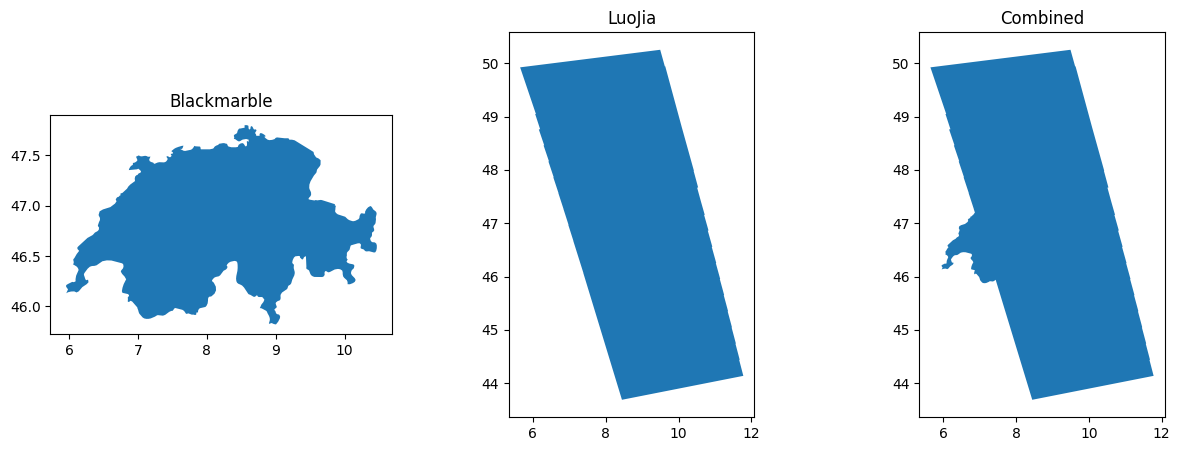

In [ ]:
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# Download BM
print("Using date:", BM_DATE)

plots: tuple[Figure, list[Axes]] = plt.subplots(1, 3, figsize=(15, 5))
fig, ax = plots
ax[0].set_title("Blackmarble")
gdf.plot(ax=ax[0])

# Get bounds from LJ
ax[1].set_title("LuoJia")
gdf_lj = gpd.GeoDataFrame(geometry=[geometry_lj], crs=lj_xarr.rio.crs)
gdf_lj.plot(ax=ax[1])

# gdf_merged = gpd.overlay(gdf, gdf_lj, how="union")
all_geoms = pd.concat([gdf.geometry, gdf_lj.geometry])
geom_merged = all_geoms.union_all(method="unary")
gdf_merged = gpd.GeoDataFrame(geometry=[geom_merged], crs=gdf.crs)

# gdf_merged.plot()
ax[2].set_title("Combined")
gdf_merged.plot(ax=ax[2])

In [5]:
from blackmarble.types import Product

from lib.bm import bm_download

bm_dataset = bm_download(
    gdf_merged,
    BM_DATE,
    product=Product.VNP46A1,
    variable=BM_VARIABLE,
    drop_values_by_quality_flag=[2, 4, 16, 512, 1024, 2048],
)
bm_xarr = bm_dataset[BM_VARIABLE].sel(time=BM_DATE.isoformat())
pc02_bm, pc98_bm = bm_xarr.quantile([0.02, 0.98])
# radiance_m10 = radiance_m10.fillna(0)

display(bm_xarr)

GETTING MANIFEST...: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


QUEUEING TASKS | Downloading...:   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/3 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Applying Quality Flag `QF_DNB` with values [2, 4, 16, 512, 1024, 2048]
Applying Quality Flag `QF_DNB` with values [2, 4, 16, 512, 1024, 2048]
Applying Quality Flag `QF_DNB` with values [2, 4, 16, 512, 1024, 2048]


COLLATING RESULTS | Processing...: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


<xarray.DataArray 'DNB_At_Sensor_Radiance_500m' (y: 1574, x: 1471)> Size: 19MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1574, 1471))
Coordinates:
  * x        (x) float64 12kB 5.652 5.656 5.66 5.665 ... 11.76 11.77 11.77 11.78
  * y        (y) float64 13kB 50.25 50.24 50.24 50.24 ... 43.71 43.7 43.7 43.69
    time     datetime64[ns] 8B 2018-09-08
Attributes:
    units:    nW/cm²sr

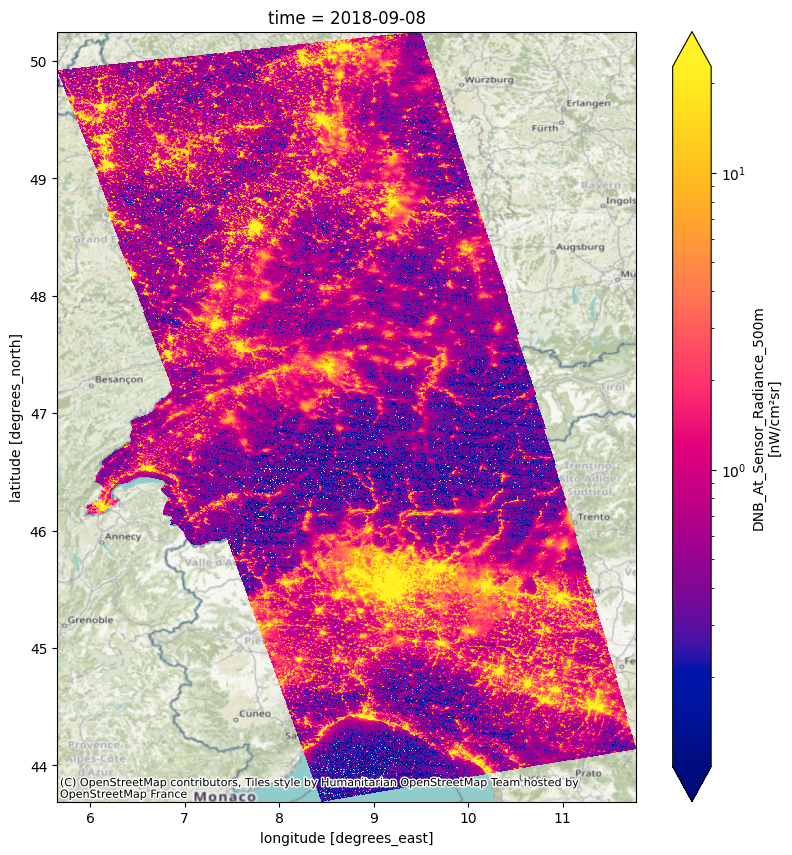

In [6]:
xmin, ymin, _, _ = gdf_merged.bounds.min(axis="index")
_, _, xmax, ymax = gdf_merged.bounds.max(axis="index")
aspect_ratio = (xmax - xmin) / (ymax - ymin)

fig, ax = plt.subplots(figsize=(10 * aspect_ratio, 10))
bm_xarr.plot.pcolormesh(ax=ax, robust=False, cmap=cc.cm.bmy, norm=LogNorm(max(pc02_bm, 1e-5), pc98_bm))
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [7]:
lj_xarr

<xarray.DataArray (y: 5131, x: 4797)> Size: 98MB
[24613407 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 38kB 5.65 5.651 5.652 5.653 ... 11.78 11.78 11.78
  * y            (y) float64 41kB 50.25 50.25 50.25 50.25 ... 43.7 43.7 43.69
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

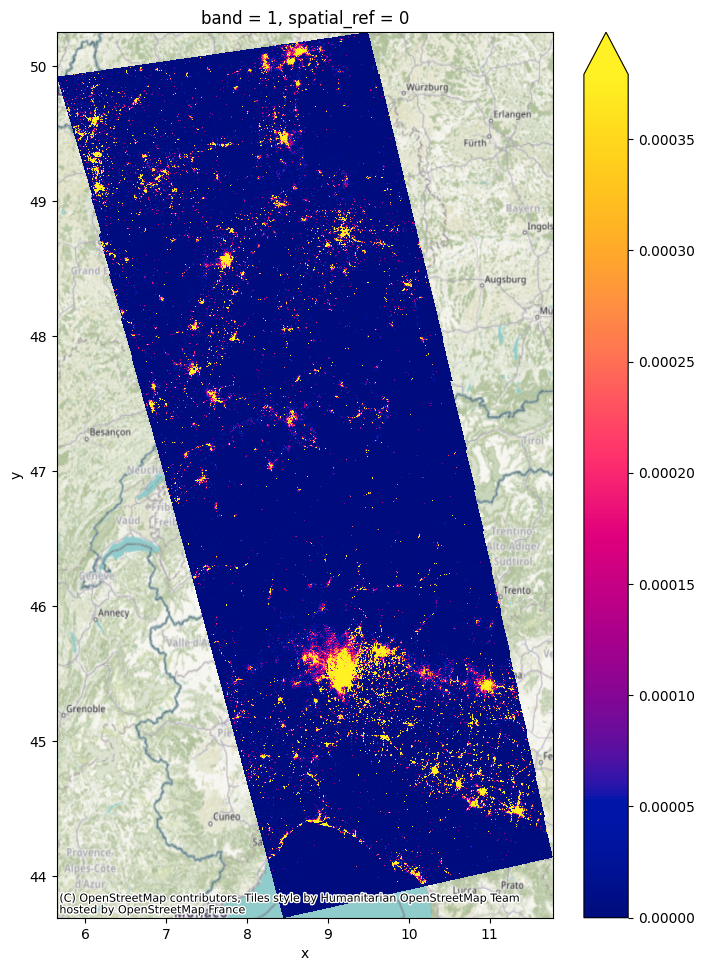

In [41]:
fix, ax = plt.subplots(figsize=(8, 11.5))
lj_xarr.plot.pcolormesh(robust=True, cmap=cc.cm.bmy)
cx.add_basemap(ax, crs=gdf.crs.to_string())

In [ ]:
import json

from lib.lj import lj_get_tile_metadata

print(json.dumps(lj_get_tile_metadata(relevant_tiles[0]), indent=4))

{
    "ProductInfo": {
        "satelliteID": "LJ01",
        "sensor": "CMOS",
        "frameIndex": "0011",
        "productLevel": "L2",
        "timeType": "UTC",
        "imagingTime": "2018-9-7T21:18:37.23503",
        "produceTime": "2018-09-08T13:16:59",
        "dataBits": "15",
        "heightInPixels": "2048",
        "widthInPixels": "2048",
        "imageColumnGSD": "129",
        "imageRowGSD": "129",
        "roll": "7.510964",
        "pitch": "0.512143",
        "yaw": "-1.535196",
        "solarAzimuth": "221.790241",
        "solarElevation": "42.951389",
        "satelliteAzimuth": "96.272461",
        "satelliteElevation": "27.109373",
        "CenterLongitude": "9.691678",
        "CenterLatitude": "45.098675",
        "LTLongitude": "10.917108",
        "LTLatitude": "46.400555",
        "RTLongitude": "11.780263",
        "RTLatitude": "44.139187",
        "RBLongitude": "8.446063",
        "RBLatitude": "43.690610",
        "LBLongitude": "7.383950",
        "L

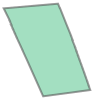

In [ ]:
from lib.lj import lj_get_region_geometry

geom_lj = lj_get_region_geometry(ADMIN_ID, LJ_DATE.isoformat())
geom_lj

Merging LuoJia geometry for CHE on 2018-09-07


<Axes: >

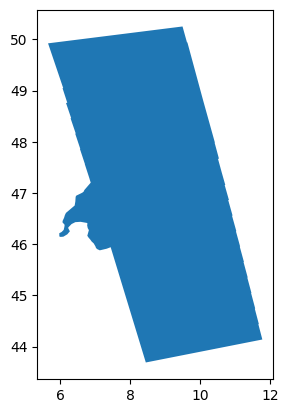

In [7]:
from lib.bm import bm_get_unified_gdf

unified_geom = bm_get_unified_gdf(ADMIN_ID, LJ_DATE)
unified_geom.plot()